<img src="https://github.com/superannotateai/automation-suites/blob/main/docs/sa_logo.png?raw=1" width="250" align="left">

#  Name

This tutorial walks you through the ```Text Classification``` automation pipeline within SuperAnnotate platform. We will utilize ```Amazon Product Reviews``` dataset, which is in fact a hierarchical text classification dataset, but in this tutorial we will treat it as a usual - single level classification dataset and will predict only the level 1 labels which reside under ```Cat1``` column. For this purpose we will proceed with the following steps: 


1. Setup the environment and install dependences
2. Run the  ```Cohere classification``` model on validation data, to understand the model performance
3. Run the  ```Cohere classification``` model on unlabeled data
4. Setup ```Text``` project at SuperAnnotate with corresponding classes and data
5. Upload model predictions to the platform 
6. Results visualized in the platform


## 1.  Environment Setup

Please hit the ```RESTART RUNTIME``` button in the installation logs below, or if it is not there manually navigate Runtime -> Restart Runtime

In [ ]:
! pip install superannotate==4.4.7 #SA SDK installation
! pip install cohere==2.9.1 #Cohere installation

# 1.1  User Variables Setup

SuperAnnotate Python SDK functions work within the team scope of the platform, so a team-level authorization is required. To authorize the package in a given team scope, get the authorization token from the team settings page.



In [ ]:
SDK_TOKEN = "ADD_YOUR_TOKEN_HERE" #Your SuperAnnotate SDK token
PROJECT_NAME = "ADD_YOUR_PROJECT_NAME_HERE" #A project with this name will be created to upload all voice files and transcribtions
COHERE_TOKEN = "ADD_YOUR_COHERE_TOKEN_HERE" #Your Cohere API token

#1.2 Constants Setup

In [ ]:
S3_BASE_URL = "https://sa-public-datasets.s3.amazonaws.com/text-datasets/hierarchical-text-classification/"
TRAIN_VAL_FILES = [
    "training-files/train_40k.csv",
    "training-files/val_10k.csv"
]
UNLABELED_FILES_BASE_URL = S3_BASE_URL + "unlabeled-files/"
UNLABELED_FILES_LIST = "unlabeled_file_names.txt"
UNLABELED_REVIEWS_CSV = "unlabeled10k.csv"

#1.3 Download the data

In [ ]:
from os.path import join, basename
import requests
import os
from tqdm import tqdm

os.makedirs('data/unlabeled-files', exist_ok=True)
for dataset_file in TRAIN_VAL_FILES:
  response = requests.get(join(S3_BASE_URL, dataset_file))
  with open(join('data', basename(dataset_file)), 'wb') as f:
    f.write(response.content)

response = requests.get(join(S3_BASE_URL, UNLABELED_FILES_LIST))
with open(join('data', UNLABELED_FILES_LIST), 'wb') as f:
  f.write(response.content)

response = requests.get(join(UNLABELED_FILES_BASE_URL, UNLABELED_REVIEWS_CSV))
with open(join('data/unlabeled-files', UNLABELED_REVIEWS_CSV), 'wb') as f:
  f.write(response.content)

with open(join('data', UNLABELED_FILES_LIST), 'r') as f:
  unlabeled_file_names = [file_name.strip() for file_name in f.readlines()]

# 2.0 Load and visualize the training data.

In [ ]:
import pandas as pd
import plotly.express as px
df = pd.read_csv('data/train_40k.csv')
fig = px.histogram(df, x="Cat1", color="Cat1")
fig.show()

We see that a significant class imbalance is present in the dataset. In fact the ```cohere.classify``` API uses provided examples to perform a few-shot learning to predict the classes of provided inputs. For this purpose to avoid long waiting times or API crashes, we will not provide the whole training set as examples, we will just randomly sample 800 entries from each of the six classes, thereby also balancing the dataset.

#2.1 Sample 4800 rows for cohere examples

In [ ]:
sampled_dfs = []
for class_name in df["Cat1"].unique():
  sampled_dfs.append(df[df["Cat1"] == class_name].sample(n=800, replace=False))
balanced_5k_reviews = pd.concat(sampled_dfs)

Cohere accepts examples and inputs with maximum length of 512 tokens. For this purpose we will process training and validation reviews and take only the first 512 tokens of each review

#2.2 Preprocess all sets

In [ ]:
import cohere
from cohere.classify import Example
from tqdm import tqdm
from multiprocessing import Pool

co = cohere.Client(COHERE_TOKEN)

def process_row_train_val(data):
  _, row = data
  tokens = co.tokenize(text=row["Text"]).tokens
  shortened_txt = co.detokenize(tokens[:512]).text
  return Example(shortened_txt, row["Cat1"])

# using multithreading to speed up the preprocessing as 
# the tokenization and detokenization are pretty slow
# while can be done parallelly

def threaded_processing(df):
  class_data = []
  with Pool(16) as pool:
    print(pool)
    max_ = df.shape[0]
    with tqdm(total=max_) as pbar:
      for processed_review in pool.imap_unordered(process_row_train_val, df.iterrows()):
        class_data.append(processed_review)
        pbar.update()
  return class_data

class_data = threaded_processing(balanced_5k_reviews)
val_df = pd.read_csv('data/val_10k.csv')
class_data_val = threaded_processing(val_df)

In [ ]:
unlabeled_df = pd.read_csv(join('data/unlabeled-files', UNLABELED_REVIEWS_CSV))
unlabled_reviews_processed = {}

def process_unlabeled_review(data):
  _, row = data
  tokens = co.tokenize(text=row['review']).tokens
  shortened_txt = co.detokenize(tokens[:512]).text
  return (row['file_name'], shortened_txt)

unlabled_reviews_processed = {}
with Pool(16) as pool:
  max_ = unlabeled_df.shape[0]
  with tqdm(total=max_) as pbar:
    for processed_review in pool.imap_unordered(process_unlabeled_review, unlabeled_df.iterrows()):
      file_name, review = processed_review
      unlabled_reviews_processed[file_name] = review
      pbar.update()

#2.3 Measure Cohere performance on the validation set

In [ ]:
from sklearn.metrics import classification_report

batch_size = 400

def get_predictions(inputs, batch_size, examples=class_data):
  class_results = []
  for i in tqdm(range(len(inputs) // batch_size)):
    batch_start_id, batch_end_id = batch_size * i, batch_size * (i + 1)
    batch_preds = co.classify(inputs=inputs[batch_start_id : batch_end_id], model='small', examples=examples)
    class_results.extend([pred.prediction for pred in batch_preds])
  
  return class_results

val_inputs = [item.text for item in class_data_val]
val_pred_results = get_predictions(val_inputs, batch_size)
print(classification_report(val_pred_results, [entry.label for entry in class_data_val]))

#3 Get predictions for the unlabeled set

In [ ]:
test_inputs = list(unlabled_reviews_processed.values())
test_pred_results = get_predictions(test_inputs, batch_size)
test_preds_mapping = dict(zip(unlabled_reviews_processed.keys(), test_pred_results))

#4 Project Setup

#4.1 Authorize SA SDK

In [ ]:
from superannotate import SAClient

sa = SAClient(token=SDK_TOKEN)

#4.2 Create the project and attach the dataset

In [ ]:
# 1. create a Text project
sa.create_project(PROJECT_NAME, "Amazon Product Reviews 10k dataset", "Document")

# 2. create dataset CSV to attach to the platform
import pandas as pd

data = {
    "name": unlabeled_file_names,
    "url": [join(UNLABELED_FILES_BASE_URL, file_name) for file_name in unlabeled_file_names]
}
df = pd.DataFrame(data)
df.to_csv('data.csv')

# 3. attach dataset
sa.attach_items(PROJECT_NAME, "./data.csv")

# 4. create classes in the SA Project
# using the colors already generated by plotly in step 2.0
class_color_plotly = {}
for hist_bin in fig.data:
  class_color_plotly[hist_bin.name.split('=')[-1].strip()] = hist_bin.marker.color.upper()

for class_name, color in class_color_plotly.items():
  sa.create_annotation_class(project=PROJECT_NAME, name=class_name, color=color, class_type='tag')

# 5. Import Predictions

# 5.1 Construct the annotation dictionaries

In [ ]:
annotations = []
for file_name, class_name in test_preds_mapping.items():
  sa_format = {
    "metadata": {
      "name": file_name
    },
    "instances": [
      {
        "type": "tag",
        "className": class_name,
      }
    ],
    "tags": [],
    "freeText": ""
  }
  annotations.append(sa_format)

# 5.2 Upload the predictions to the platform

In [ ]:
sa.upload_annotations(PROJECT_NAME, annotations)

# 6. Results visualized in the platform

After finishing all these steps you can navigate to the [SuperAnnotate Platform](https://app.superannotate.com), login choose your team (to which the SDK_TOKEN in this tutorial belongs). There a new project with PROJECT_NAME should be created. When opening any of the text files in that project you will see the editor display as seen below: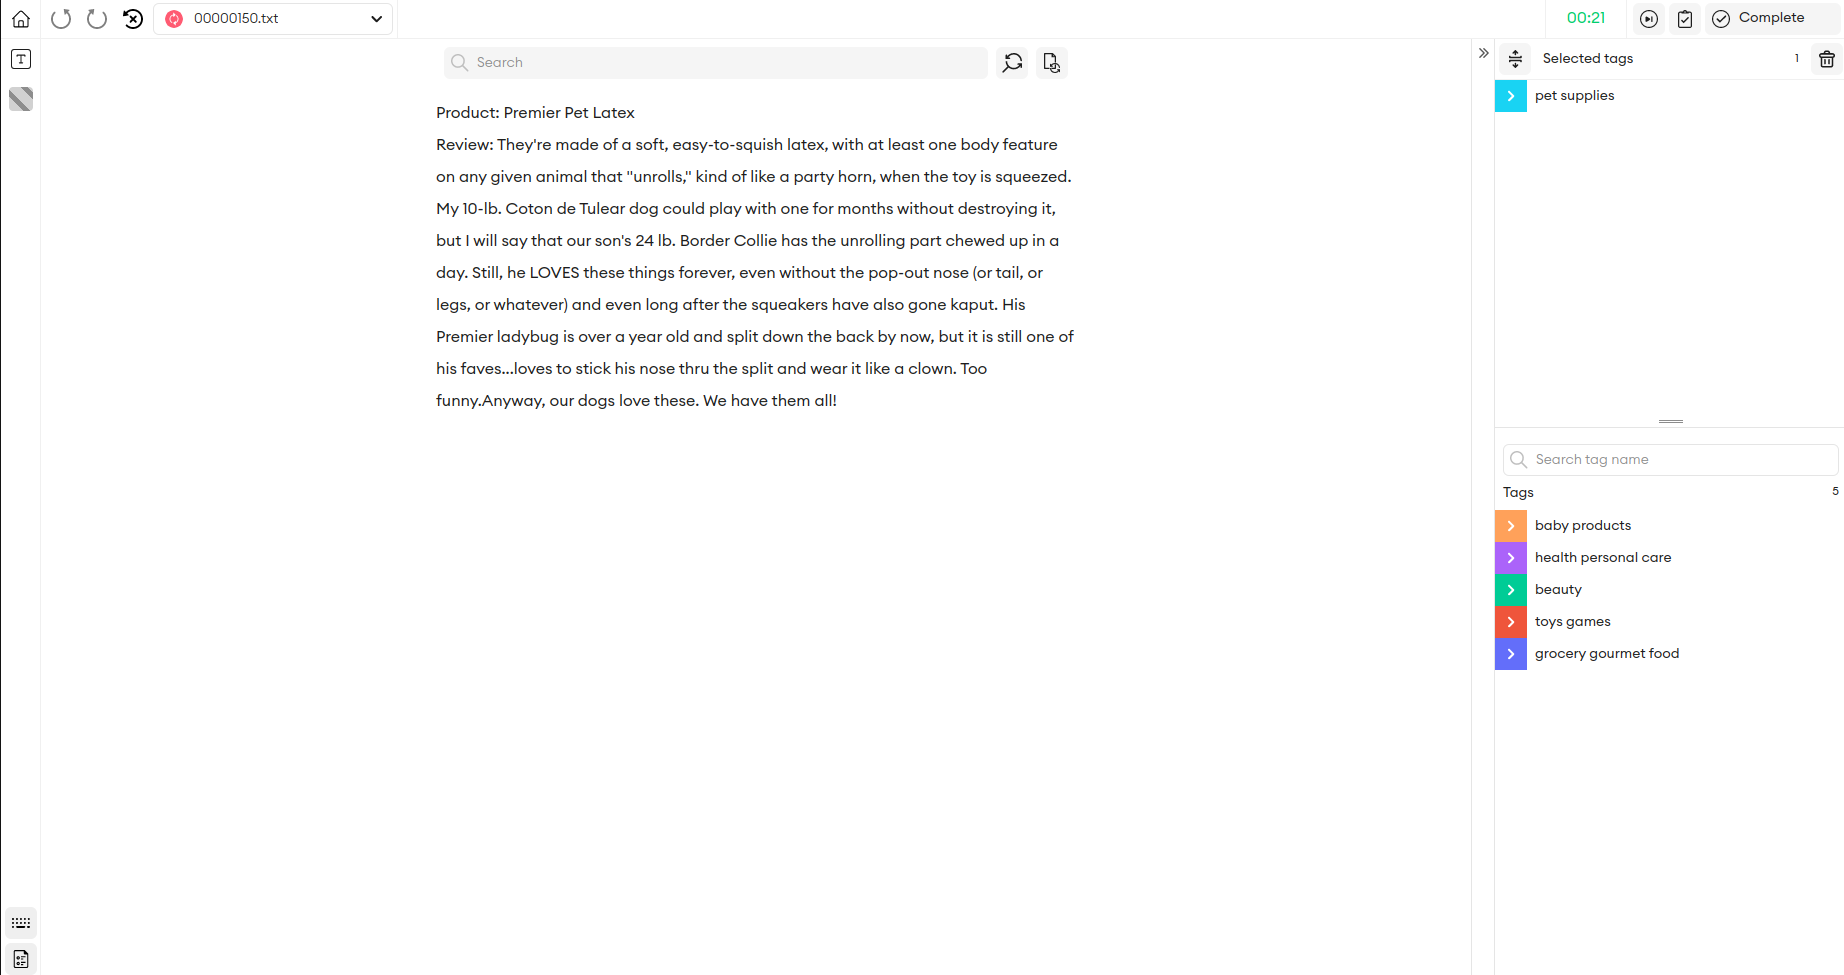
where on the right side panel, under the "Selected tags" you can see the Cohere predicted label for the review.